# Imports

In [2]:
%matplotlib inline 

import os
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from astropy.table import Table
from scipy.interpolate import RectBivariateSpline
from scipy.optimize import curve_fit
from functools import reduce

import model_flux_ratio as mfr
import pca

In [3]:
path = os.getcwd()

We have Storey & Sochi's 2015 (SS2015) hydrogen emissivities, which do not go down to log(ne)=0,1, and Storey's 2018 (S2018) emissivities, calculated down to log(ne)=0. From these two datasets and respective extrapolations/interpolations, we will decide what is best for our Yp analysis. We attempt a PCA to extrapolate SS2015 down to our necessary densities, and an interpolation of S2018 to a finer grid. 

# PCA on SS2015 emissivities

In [4]:
hydrogen_emis_noextrap = Table.read(path+'/tables/hydrogen_emissivity_noextrap', format='ascii', delimiter='\t')

## scipy.curvefit()

The Storey & Sochi 2015 hydrogen emissivities only go down to a density of n_e=100. We are using a PCA to extrapolate down to lower densities but first need to fit a curve to the existing values

### Functional form for the fit to emissivities

In [5]:
def functional_form(T, a, b, c, d):
    #emis = ( a - (b * np.log(T)**2) + (c * np.log(T)) + (d / np.log(T)) ) * T**-1
    
    # Need to use a polynomial (instead of our original modified polynomial above) to match
    # the polynomial fit that is going on in PCA
    emis = ( a + (b * np.log10(T)) + (c * np.log10(T)**2) + (d * np.log10(T)**3) )

    return emis

### Temperature and density range for fit

Fitting only the temperature range ~5000-25000 K, for (1) a better fit in (2) the range we really care about

In [6]:
# New temperature array only between ~5000-25000, matched to the SS2015 temperature values
temps = 10**np.linspace(3.7, 4.4, num=8) # np.arange(5000, 25000, 1000)
print (temps)

[ 5011.87233627  6309.5734448   7943.28234724 10000.
 12589.25411794 15848.93192461 19952.62314969 25118.8643151 ]


These densities correspond to those given as data points from the Storey & Sochi 2015 hydrogen emissivities

In [7]:
dens = 10**np.array([2,3,4,5,6])
print (dens, len(dens))

[    100    1000   10000  100000 1000000] 5


### Fit!

In [8]:
# Empty arrays to save the coefficients of our functional form from scipy's curve_fit
# Our functional form has 4 coefficients: a, b, c, d and we will have one at each density value
# (i.e., at n_e = 100, there will be a, b, c, d; at n_e = 1000, there will be a, b, c, d)
ha_a_coeff = np.zeros(len(dens))
ha_b_coeff = np.zeros(len(dens))
ha_c_coeff = np.zeros(len(dens))
ha_d_coeff = np.zeros(len(dens))

hb_a_coeff = np.zeros(len(dens))
hb_b_coeff = np.zeros(len(dens))
hb_c_coeff = np.zeros(len(dens))
hb_d_coeff = np.zeros(len(dens))

hg_a_coeff = np.zeros(len(dens))
hg_b_coeff = np.zeros(len(dens))
hg_c_coeff = np.zeros(len(dens))
hg_d_coeff = np.zeros(len(dens))

hd_a_coeff = np.zeros(len(dens))
hd_b_coeff = np.zeros(len(dens))
hd_c_coeff = np.zeros(len(dens))
hd_d_coeff = np.zeros(len(dens))

h8_a_coeff = np.zeros(len(dens))
h8_b_coeff = np.zeros(len(dens))
h8_c_coeff = np.zeros(len(dens))
h8_d_coeff = np.zeros(len(dens))

pg_a_coeff = np.zeros(len(dens))
pg_b_coeff = np.zeros(len(dens))
pg_c_coeff = np.zeros(len(dens))
pg_d_coeff = np.zeros(len(dens))

In [9]:
# Open .pdf to save emissivity and residual plots in
ha_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/halpha_curvefits_residuals.pdf')
hg_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/hgamma_curvefits_residuals.pdf')
hd_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/hdelta_curvefits_residuals.pdf')
h8_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/h8_curvefits_residuals.pdf')
pg_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/pg_curvefits_residuals.pdf')

# Loop through density values for which we have data
for dens_val in range(len(dens)):
    # Find indices in hydrogen_emissivity_noextrap that correspond to Balmer transitions of interest
    # and pull the emissivity values at those indices
    ss2015_ha = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], \
                    np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                    np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(dens[dens_val]))))]
    ss2015_hb = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 4)[0], \
                    np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                    np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(dens[dens_val]))))]
    ss2015_hg = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 5)[0], \
                    np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                    np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(dens[dens_val]))))]
    ss2015_hd = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 6)[0], \
                    np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                    np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(dens[dens_val]))))]
    ss2015_h8 = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 8)[0], \
                    np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                    np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(dens[dens_val]))))]
    ss2015_pg = 1e25*hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 6)[0], \
                    np.where(hydrogen_emis_noextrap['Nl'] == 3)[0], \
                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0], \
                    np.where(hydrogen_emis_noextrap['log(ne)'] == np.log10(dens[dens_val]))))]

    # Fit a functional form to our new extrapolated emissivities
    popta, pcova = curve_fit(functional_form, temps, ss2015_ha)
    ha_a_coeff[dens_val] = popta[0]
    ha_b_coeff[dens_val] = popta[1]
    ha_c_coeff[dens_val] = popta[2]
    ha_d_coeff[dens_val] = popta[3]
     
    poptb, pcovb = curve_fit(functional_form, temps, ss2015_hb)
    hb_a_coeff[dens_val] = poptb[0]
    hb_b_coeff[dens_val] = poptb[1]
    hb_c_coeff[dens_val] = poptb[2]
    hb_d_coeff[dens_val] = poptb[3]
    
    poptg, pcovg = curve_fit(functional_form, temps, ss2015_hg)
    hg_a_coeff[dens_val] = poptg[0]
    hg_b_coeff[dens_val] = poptg[1]
    hg_c_coeff[dens_val] = poptg[2]
    hg_d_coeff[dens_val] = poptg[3]
    
    poptd, pcovd = curve_fit(functional_form, temps, ss2015_hd)
    hd_a_coeff[dens_val] = poptd[0]
    hd_b_coeff[dens_val] = poptd[1]
    hd_c_coeff[dens_val] = poptd[2]
    hd_d_coeff[dens_val] = poptd[3]
    
    popt8, pcov8 = curve_fit(functional_form, temps, ss2015_h8)
    h8_a_coeff[dens_val] = popt8[0]
    h8_b_coeff[dens_val] = popt8[1]
    h8_c_coeff[dens_val] = popt8[2]
    h8_d_coeff[dens_val] = popt8[3]
    
    poptpg, pcovpg = curve_fit(functional_form, temps, ss2015_pg)
    pg_a_coeff[dens_val] = poptpg[0]
    pg_b_coeff[dens_val] = poptpg[1]
    pg_c_coeff[dens_val] = poptpg[2]
    pg_d_coeff[dens_val] = poptpg[3]
    

## Now do PCA

In [10]:
import importlib
importlib.reload(pca)
importlib.reload(mfr)

<module 'model_flux_ratio' from '/Users/thsyu/Software/Yp/model_flux_ratio.py'>

This is PypeIt's call to pca.basis and what each variable passed in means, for reference

### PCA input parameters

In [11]:
temps_arr = np.log10(np.repeat(temps, dens.size)).reshape(8,5) #np.log10(np.tile(temps, (5, 1)))
# Need emis_arr to be emissivities at these temperatures and at the different densities..!\

ha_emis_at_td = np.zeros((5,8))
hb_emis_at_td = np.zeros((5,8))
hg_emis_at_td = np.zeros((5,8))
hd_emis_at_td = np.zeros((5,8))
h8_emis_at_td = np.zeros((5,8))
pg_emis_at_td = np.zeros((5,8))

for i in range(dens.size):
    ha_emis_at_td[i] = functional_form(temps, ha_a_coeff[i], ha_b_coeff[i], ha_c_coeff[i], ha_d_coeff[i])
    hb_emis_at_td[i] = functional_form(temps, hb_a_coeff[i], hb_b_coeff[i], hb_c_coeff[i], hb_d_coeff[i])
    hg_emis_at_td[i] = functional_form(temps, hg_a_coeff[i], hg_b_coeff[i], hg_c_coeff[i], hg_d_coeff[i])
    hd_emis_at_td[i] = functional_form(temps, hd_a_coeff[i], hd_b_coeff[i], hd_c_coeff[i], hd_d_coeff[i])
    h8_emis_at_td[i] = functional_form(temps, h8_a_coeff[i], h8_b_coeff[i], h8_c_coeff[i], h8_d_coeff[i])
    pg_emis_at_td[i] = functional_form(temps, pg_a_coeff[i], pg_b_coeff[i], pg_c_coeff[i], pg_d_coeff[i])

ha_emis_arr = np.dstack((ha_emis_at_td[0], ha_emis_at_td[1], ha_emis_at_td[2], ha_emis_at_td[3], ha_emis_at_td[4]))[0]
hb_emis_arr = np.dstack((hb_emis_at_td[0], hb_emis_at_td[1], hb_emis_at_td[2], hb_emis_at_td[3], hb_emis_at_td[4]))[0]
hg_emis_arr = np.dstack((hg_emis_at_td[0], hg_emis_at_td[1], hg_emis_at_td[2], hg_emis_at_td[3], hg_emis_at_td[4]))[0]
hd_emis_arr = np.dstack((hd_emis_at_td[0], hd_emis_at_td[1], hd_emis_at_td[2], hd_emis_at_td[3], hd_emis_at_td[4]))[0]
h8_emis_arr = np.dstack((h8_emis_at_td[0], h8_emis_at_td[1], h8_emis_at_td[2], h8_emis_at_td[3], h8_emis_at_td[4]))[0]
pg_emis_arr = np.dstack((pg_emis_at_td[0], pg_emis_at_td[1], pg_emis_at_td[2], pg_emis_at_td[3], pg_emis_at_td[4]))[0]

ha_coeffs = np.stack((ha_a_coeff, ha_b_coeff, ha_c_coeff, ha_d_coeff))
hb_coeffs = np.stack((hb_a_coeff, hb_b_coeff, hb_c_coeff, hb_d_coeff))
hg_coeffs = np.stack((hg_a_coeff, hg_b_coeff, hg_c_coeff, hg_d_coeff))
hd_coeffs = np.stack((hd_a_coeff, hd_b_coeff, hd_c_coeff, hd_d_coeff))
h8_coeffs = np.stack((h8_a_coeff, h8_b_coeff, h8_c_coeff, h8_d_coeff))
pg_coeffs = np.stack((pg_a_coeff, pg_b_coeff, pg_c_coeff, pg_d_coeff))

ofit = np.array([1,1,1,1])
lnpc = len(ofit) - 1
dens_arr = np.log10(dens)


## Run PCA

In [12]:
ha_fitted, ha_outpar = pca.basis(temps_arr, ha_emis_arr, ha_coeffs, lnpc, ofit, x0in=dens_arr, skipx0=False)
hb_fitted, hb_outpar = pca.basis(temps_arr, hb_emis_arr, hb_coeffs, lnpc, ofit, x0in=dens_arr, skipx0=False)
hg_fitted, hg_outpar = pca.basis(temps_arr, hg_emis_arr, hg_coeffs, lnpc, ofit, x0in=dens_arr, skipx0=False)
hd_fitted, hd_outpar = pca.basis(temps_arr, hd_emis_arr, hd_coeffs, lnpc, ofit, x0in=dens_arr, skipx0=False)
h8_fitted, h8_outpar = pca.basis(temps_arr, h8_emis_arr, h8_coeffs, lnpc, ofit, x0in=dens_arr, skipx0=False)
pg_fitted, pg_outpar = pca.basis(temps_arr, pg_emis_arr, pg_coeffs, lnpc, ofit, x0in=dens_arr, skipx0=False)


Reduced chi-squared = 7.559376E-07
Reduced chi-squared = 7.693935E-06
Reduced chi-squared = 3.572147E-06
Reduced chi-squared = 2.291384E-06
Reduced chi-squared = 2.976358E-06
Reduced chi-squared = 8.684406E-11


## Interpolation of densities (although using pca.extrapolate())

### Grid of densities for interpolation

In [13]:
extrap_ne_array = np.array([0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]) #np.array([0,1,2,3,4,5,6]) #np.linspace(0, 6, 100)

In [14]:
SS2015_ha_extfit, ha_outpar2 = pca.extrapolate(ha_outpar, extrap_ne_array)
SS2015_hb_extfit, hb_outpar2 = pca.extrapolate(hb_outpar, extrap_ne_array)
SS2015_hg_extfit, hg_outpar2 = pca.extrapolate(hg_outpar, extrap_ne_array)
SS2015_hd_extfit, hd_outpar2 = pca.extrapolate(hd_outpar, extrap_ne_array)
SS2015_h8_extfit, h8_outpar2 = pca.extrapolate(h8_outpar, extrap_ne_array)
SS2015_pg_extfit, pg_outpar2 = pca.extrapolate(pg_outpar, extrap_ne_array)

In [15]:
pca.pca_plot(ha_outpar, ofit, 'pca_1111_ha')
pca.pca_plot(hb_outpar, ofit, 'pca_1111_hb')
pca.pca_plot(hg_outpar, ofit, 'pca_1111_hg')
pca.pca_plot(hd_outpar, ofit, 'pca_1111_hd')
pca.pca_plot(h8_outpar, ofit, 'pca_1111_h8')
pca.pca_plot(pg_outpar, ofit, 'pca_1111_pg')

<Figure size 640x480 with 0 Axes>

### PCA's interpolation

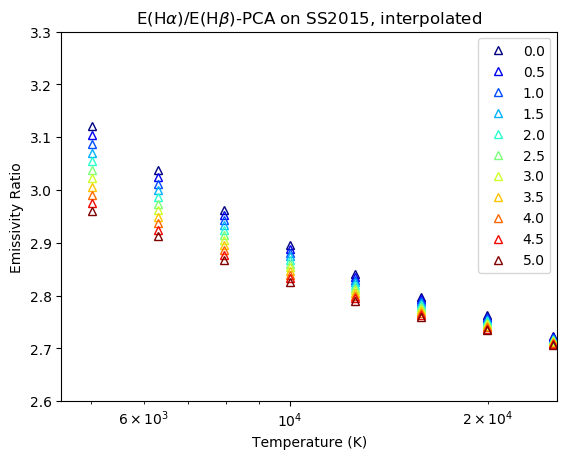

In [16]:
color = cm.jet(np.linspace(0,1,len(extrap_ne_array)))

for i in range(len(extrap_ne_array)):
    leg_label = str(extrap_ne_array[i]) #+ ', PCA'
    plt.plot(temps, SS2015_ha_extfit.T[i]/SS2015_hb_extfit.T[i], label=leg_label, marker='^', linestyle='None', fillstyle='none', color=color[i])

plt.xlabel('Temperature (K)')
plt.ylabel('Emissivity Ratio')
plt.title(r'E(H$\alpha$)/E(H$\beta$)-PCA on SS2015, interpolated')
plt.xlim(4500, 25500)
plt.ylim(2.6, 3.3)
plt.xscale('log')
plt.legend()
#plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/SS2015_PCA_interp.pdf', overwrite=True)
plt.show()

# PCA on S2018 emissivities onto finer density grid

In [17]:
hydrogen_emis_S2018 = Table.read(path+'/tables/r1B/hydrogen_emissivity_storey2018', format='ascii', delimiter='\t')

In [18]:
# T=5000-25000, matched to the S2018 temperature grid
temps = np.arange(5000, 26000, 1000)
print (temps, len(temps))

# Density array, matched to the S2018 density grid
dens = np.array([0,1,2,3,4,5])
print (dens, len(dens))

[ 5000  6000  7000  8000  9000 10000 11000 12000 13000 14000 15000 16000
 17000 18000 19000 20000 21000 22000 23000 24000 25000] 21
[0 1 2 3 4 5] 6


In [19]:
# Empty arrays to save the coefficients of our functional form from scipy's curve_fit
# Our functional form has 4 coefficients: a, b, c, d and we will have one at each density value
# (i.e., at n_e = 100, there will be a, b, c, d; at n_e = 1000, there will be a, b, c, d)
ha_a_coeff = np.zeros(len(dens))
ha_b_coeff = np.zeros(len(dens))
ha_c_coeff = np.zeros(len(dens))
ha_d_coeff = np.zeros(len(dens))

hb_a_coeff = np.zeros(len(dens))
hb_b_coeff = np.zeros(len(dens))
hb_c_coeff = np.zeros(len(dens))
hb_d_coeff = np.zeros(len(dens))

hg_a_coeff = np.zeros(len(dens))
hg_b_coeff = np.zeros(len(dens))
hg_c_coeff = np.zeros(len(dens))
hg_d_coeff = np.zeros(len(dens))

hd_a_coeff = np.zeros(len(dens))
hd_b_coeff = np.zeros(len(dens))
hd_c_coeff = np.zeros(len(dens))
hd_d_coeff = np.zeros(len(dens))

h8_a_coeff = np.zeros(len(dens))
h8_b_coeff = np.zeros(len(dens))
h8_c_coeff = np.zeros(len(dens))
h8_d_coeff = np.zeros(len(dens))

pg_a_coeff = np.zeros(len(dens))
pg_b_coeff = np.zeros(len(dens))
pg_c_coeff = np.zeros(len(dens))
pg_d_coeff = np.zeros(len(dens))

In [20]:
# Loop through density values for which we have data
for dens_val in range(len(dens)):
    # Find indices in hydrogen_emissivity_S2018 and pull the emissivity values at those indices
    s2018_ha = 1e25*hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_S2018['Nu'] == 3)[0], \
                    np.where(hydrogen_emis_S2018['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_S2018['log(ne)'] == dens[dens_val])))]
    s2018_hb = 1e25*hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_S2018['Nu'] == 4)[0], \
                    np.where(hydrogen_emis_S2018['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_S2018['log(ne)'] == dens[dens_val])))]
    s2018_hg = 1e25*hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_S2018['Nu'] == 5)[0], \
                    np.where(hydrogen_emis_S2018['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_S2018['log(ne)'] == dens[dens_val])))]
    s2018_hd = 1e25*hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_S2018['Nu'] == 6)[0], \
                    np.where(hydrogen_emis_S2018['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_S2018['log(ne)'] == dens[dens_val])))]
    s2018_h8 = 1e25*hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_S2018['Nu'] == 8)[0], \
                    np.where(hydrogen_emis_S2018['Nl'] == 2)[0], \
                    np.where(hydrogen_emis_S2018['log(ne)'] == dens[dens_val])))]
    s2018_pg = 1e25*hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_S2018['Nu'] == 6)[0], \
                    np.where(hydrogen_emis_S2018['Nl'] == 3)[0], \
                    np.where(hydrogen_emis_S2018['log(ne)'] == dens[dens_val])))]

    # Fit a functional form to our new extrapolated emissivities
    popta, pcova = curve_fit(functional_form, temps, s2018_ha)
    ha_a_coeff[dens_val] = popta[0]
    ha_b_coeff[dens_val] = popta[1]
    ha_c_coeff[dens_val] = popta[2]
    ha_d_coeff[dens_val] = popta[3]
     
    poptb, pcovb = curve_fit(functional_form, temps, s2018_hb)
    hb_a_coeff[dens_val] = poptb[0]
    hb_b_coeff[dens_val] = poptb[1]
    hb_c_coeff[dens_val] = poptb[2]
    hb_d_coeff[dens_val] = poptb[3]
    
    poptg, pcovg = curve_fit(functional_form, temps, s2018_hg)
    hg_a_coeff[dens_val] = poptg[0]
    hg_b_coeff[dens_val] = poptg[1]
    hg_c_coeff[dens_val] = poptg[2]
    hg_d_coeff[dens_val] = poptg[3]
    
    poptd, pcovd = curve_fit(functional_form, temps, s2018_hd)
    hd_a_coeff[dens_val] = poptd[0]
    hd_b_coeff[dens_val] = poptd[1]
    hd_c_coeff[dens_val] = poptd[2]
    hd_d_coeff[dens_val] = poptd[3]
    
    popt8, pcov8 = curve_fit(functional_form, temps, s2018_h8)
    h8_a_coeff[dens_val] = popt8[0]
    h8_b_coeff[dens_val] = popt8[1]
    h8_c_coeff[dens_val] = popt8[2]
    h8_d_coeff[dens_val] = popt8[3]
    
    poptpg, pcovpg = curve_fit(functional_form, temps, s2018_pg)
    pg_a_coeff[dens_val] = poptpg[0]
    pg_b_coeff[dens_val] = poptpg[1]
    pg_c_coeff[dens_val] = poptpg[2]
    pg_d_coeff[dens_val] = poptpg[3]
    

In [21]:
import importlib
importlib.reload(pca)
importlib.reload(mfr)

<module 'model_flux_ratio' from '/Users/thsyu/Software/Yp/model_flux_ratio.py'>

In [22]:
# Create a 2D grid of log10(temperatures) so we can create a 2D grid of emissivities at these values:
#    -- densities -->
#   |
# temperatures
#  |
#  v

temps_arr = np.log10(np.repeat(temps, dens.size).reshape(21,6))

ha_emis_at_td = np.zeros((6,21))
hb_emis_at_td = np.zeros((6,21))
hg_emis_at_td = np.zeros((6,21))
hd_emis_at_td = np.zeros((6,21))
h8_emis_at_td = np.zeros((6,21))
pg_emis_at_td = np.zeros((6,21))

for i in range(dens.size):
    ha_emis_at_td[i] = functional_form(temps, ha_a_coeff[i], ha_b_coeff[i], ha_c_coeff[i], ha_d_coeff[i])
    hb_emis_at_td[i] = functional_form(temps, hb_a_coeff[i], hb_b_coeff[i], hb_c_coeff[i], hb_d_coeff[i])
    hg_emis_at_td[i] = functional_form(temps, hg_a_coeff[i], hg_b_coeff[i], hg_c_coeff[i], hg_d_coeff[i])
    hd_emis_at_td[i] = functional_form(temps, hd_a_coeff[i], hd_b_coeff[i], hd_c_coeff[i], hd_d_coeff[i])
    h8_emis_at_td[i] = functional_form(temps, h8_a_coeff[i], h8_b_coeff[i], h8_c_coeff[i], h8_d_coeff[i])
    pg_emis_at_td[i] = functional_form(temps, pg_a_coeff[i], pg_b_coeff[i], pg_c_coeff[i], pg_d_coeff[i])

ha_emis_arr = np.dstack((ha_emis_at_td[0], ha_emis_at_td[1], ha_emis_at_td[2], ha_emis_at_td[3], ha_emis_at_td[4], ha_emis_at_td[5]))[0]
hb_emis_arr = np.dstack((hb_emis_at_td[0], hb_emis_at_td[1], hb_emis_at_td[2], hb_emis_at_td[3], hb_emis_at_td[4], hb_emis_at_td[5]))[0]
hg_emis_arr = np.dstack((hg_emis_at_td[0], hg_emis_at_td[1], hg_emis_at_td[2], hg_emis_at_td[3], hg_emis_at_td[4], hg_emis_at_td[5]))[0]
hd_emis_arr = np.dstack((hd_emis_at_td[0], hd_emis_at_td[1], hd_emis_at_td[2], hd_emis_at_td[3], hd_emis_at_td[4], hd_emis_at_td[5]))[0]
h8_emis_arr = np.dstack((h8_emis_at_td[0], h8_emis_at_td[1], h8_emis_at_td[2], h8_emis_at_td[3], h8_emis_at_td[4], h8_emis_at_td[5]))[0]
pg_emis_arr = np.dstack((pg_emis_at_td[0], pg_emis_at_td[1], pg_emis_at_td[2], pg_emis_at_td[3], pg_emis_at_td[4], pg_emis_at_td[5]))[0]

ha_coeffs = np.stack((ha_a_coeff, ha_b_coeff, ha_c_coeff, ha_d_coeff))
hb_coeffs = np.stack((hb_a_coeff, hb_b_coeff, hb_c_coeff, hb_d_coeff))
hg_coeffs = np.stack((hg_a_coeff, hg_b_coeff, hg_c_coeff, hg_d_coeff))
hd_coeffs = np.stack((hd_a_coeff, hd_b_coeff, hd_c_coeff, hd_d_coeff))
h8_coeffs = np.stack((h8_a_coeff, h8_b_coeff, h8_c_coeff, h8_d_coeff))
pg_coeffs = np.stack((pg_a_coeff, pg_b_coeff, pg_c_coeff, pg_d_coeff))

ofit = np.array([1,1,1,1])
lnpc = len(ofit) - 1
dens_arr = dens


In [23]:
ha_fitted, ha_outpar = pca.basis(temps_arr, ha_emis_arr, ha_coeffs, lnpc, ofit, x0in=dens_arr, skipx0=False)
hb_fitted, hb_outpar = pca.basis(temps_arr, hb_emis_arr, hb_coeffs, lnpc, ofit, x0in=dens_arr, skipx0=False)
hg_fitted, hg_outpar = pca.basis(temps_arr, hg_emis_arr, hg_coeffs, lnpc, ofit, x0in=dens_arr, skipx0=False)
hd_fitted, hd_outpar = pca.basis(temps_arr, hd_emis_arr, hd_coeffs, lnpc, ofit, x0in=dens_arr, skipx0=False)
h8_fitted, h8_outpar = pca.basis(temps_arr, h8_emis_arr, h8_coeffs, lnpc, ofit, x0in=dens_arr, skipx0=False)
pg_fitted, pg_outpar = pca.basis(temps_arr, pg_emis_arr, pg_coeffs, lnpc, ofit, x0in=dens_arr, skipx0=False)


Reduced chi-squared = 5.551288E-07
Reduced chi-squared = 1.777605E-06
Reduced chi-squared = 7.129338E-07
Reduced chi-squared = 2.809743E-07
Reduced chi-squared = 1.107642E-07
Reduced chi-squared = 8.131921E-11


In [24]:
refined_ne_array = np.arange(0, 5.5, 0.5)
print (refined_ne_array)

[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


In [25]:
S2018_ha_extfit, ha_outpar2 = pca.extrapolate(ha_outpar, refined_ne_array)
S2018_hb_extfit, hb_outpar2 = pca.extrapolate(hb_outpar, refined_ne_array)
S2018_hg_extfit, hg_outpar2 = pca.extrapolate(hg_outpar, refined_ne_array)
S2018_hd_extfit, hd_outpar2 = pca.extrapolate(hd_outpar, refined_ne_array)
S2018_h8_extfit, h8_outpar2 = pca.extrapolate(h8_outpar, refined_ne_array)
S2018_pg_extfit, pg_outpar2 = pca.extrapolate(pg_outpar, refined_ne_array)

In [26]:
pca.pca_plot(ha_outpar, ofit, 'S2018_pca_1111_ha')
pca.pca_plot(hb_outpar, ofit, 'S2018_pca_1111_hb')
pca.pca_plot(hg_outpar, ofit, 'S2018_pca_1111_hg')
pca.pca_plot(hd_outpar, ofit, 'S2018_pca_1111_hd')
pca.pca_plot(h8_outpar, ofit, 'S2018_pca_1111_h8')
pca.pca_plot(pg_outpar, ofit, 'S2018_pca_1111_pg')

<Figure size 640x480 with 0 Axes>

## Write PCA-interpolated emissivities (onto a finer density grid)

In [27]:
S2018_densinterp = open('hydrogen_emissivity_storey2018_densityPCAinterp', 'w')
for i in range(len(refined_ne_array)):
    for t in range(len(temps)):
        S2018_densinterp.write('3 2 ' + str(refined_ne_array[i]) + ' ' + str(temps[t]) + ' ' + str(S2018_ha_extfit.T[i][t]*1e-25))
        S2018_densinterp.write('\n')
        S2018_densinterp.write('4 2 ' + str(refined_ne_array[i]) + ' ' + str(temps[t]) + ' ' + str(S2018_hb_extfit.T[i][t]*1e-25))
        S2018_densinterp.write('\n')
        S2018_densinterp.write('5 2 ' + str(refined_ne_array[i]) + ' ' + str(temps[t]) + ' ' + str(S2018_hg_extfit.T[i][t]*1e-25))
        S2018_densinterp.write('\n')
        S2018_densinterp.write('6 2 ' + str(refined_ne_array[i]) + ' ' + str(temps[t]) + ' ' + str(S2018_hd_extfit.T[i][t]*1e-25))
        S2018_densinterp.write('\n')
        S2018_densinterp.write('8 2 ' + str(refined_ne_array[i]) + ' ' + str(temps[t]) + ' ' + str(S2018_h8_extfit.T[i][t]*1e-25))
        S2018_densinterp.write('\n')
        S2018_densinterp.write('6 3 ' + str(refined_ne_array[i]) + ' ' + str(temps[t]) + ' ' + str(S2018_pg_extfit.T[i][t]*1e-25))
        S2018_densinterp.write('\n')
        
S2018_densinterp.close()

## Plot interpolated emissivities

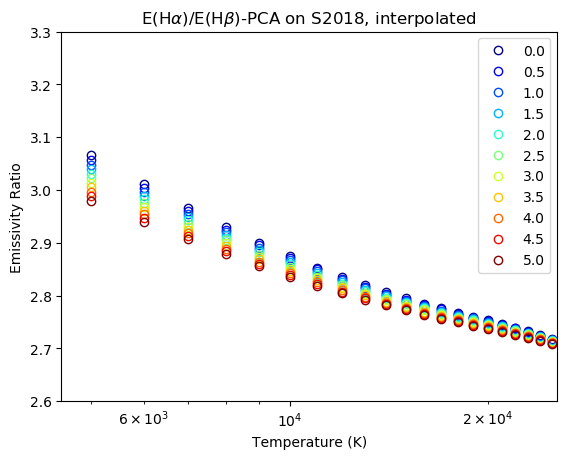

In [28]:
color = cm.jet(np.linspace(0,1,len(refined_ne_array)))

for i in range(len(refined_ne_array)):
    leg_label = str(refined_ne_array[i]) #+ ', PCA'
    plt.plot(temps, S2018_ha_extfit.T[i]/S2018_hb_extfit.T[i], label=leg_label, marker='o', linestyle='None', fillstyle='none', color=color[i])
plt.xlabel('Temperature (K)')
plt.ylabel('Emissivity Ratio')
plt.title(r'E(H$\alpha$)/E(H$\beta$)-PCA on S2018, interpolated')
plt.xlim(4500, 25500)
plt.ylim(2.6, 3.3)
plt.xscale('log')
plt.legend()
#plt.savefig('/Users/thsyu/Dropbox/BCDs/primordial_helium/S2018_PCA_interp.pdf', overwrite=True)
plt.show()

# Comparison Plot!!!!

In [35]:
SS2015_temps = 10**np.linspace(3.7, 4.4, num=8)
S2018_temps = np.arange(5000, 26000, 1000)
refined_T_array = np.arange(5000, 26000, 500)

SS2015_dens = np.arange(2,7) # log(ne)=2-6
S2018_dens = np.arange(0,6) # log(ne)=0-5

In [36]:
print (len(SS2015_temps), len(extrap_ne_array), SS2015_ha_extfit.shape)

8 11 (8, 11)


## Just RectBivariateSpline

In [74]:
ha_RBS = np.zeros((21,6))
hb_RBS = np.zeros((21,6))
hg_RBS = np.zeros((21,6))
hd_RBS = np.zeros((21,6))
h8_RBS = np.zeros((21,6))
pg_RBS = np.zeros((21,6))

for t in range(len(S2018_temps)):
    ha_RBS[t] = hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_S2018['Nu'] == 3)[0], \
                                                          np.where(hydrogen_emis_S2018['Nl'] == 2)[0], \
                                                          np.where(hydrogen_emis_S2018['T'] == S2018_temps[t])))]
    hb_RBS[t] = hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_S2018['Nu'] == 4)[0], \
                                                          np.where(hydrogen_emis_S2018['Nl'] == 2)[0], \
                                                          np.where(hydrogen_emis_S2018['T'] == S2018_temps[t])))]
    hg_RBS[t] = hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_S2018['Nu'] == 5)[0], \
                                                          np.where(hydrogen_emis_S2018['Nl'] == 2)[0], \
                                                          np.where(hydrogen_emis_S2018['T'] == S2018_temps[t])))]
    hd_RBS[t] = hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_S2018['Nu'] == 6)[0], \
                                                          np.where(hydrogen_emis_S2018['Nl'] == 2)[0], \
                                                          np.where(hydrogen_emis_S2018['T'] == S2018_temps[t])))]
    h8_RBS[t] = hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_S2018['Nu'] == 8)[0], \
                                                          np.where(hydrogen_emis_S2018['Nl'] == 2)[0], \
                                                          np.where(hydrogen_emis_S2018['T'] == S2018_temps[t])))]
    pg_RBS[t] = hydrogen_emis_S2018['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_S2018['Nu'] == 6)[0], \
                                                          np.where(hydrogen_emis_S2018['Nl'] == 3)[0], \
                                                          np.where(hydrogen_emis_S2018['T'] == S2018_temps[t])))]

In [75]:
SS2015_ha_interp = RectBivariateSpline(SS2015_temps, SS2015_dens, \
                                       hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 3)[0], \
                                                                                                    np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                                                                                                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0]))].reshape(SS2015_temps.size, SS2015_dens.size), kx=3, ky=3)
SS2015_hb_interp = RectBivariateSpline(SS2015_temps, SS2015_dens, \
                                       hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 4)[0], \
                                                                                                    np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                                                                                                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0]))].reshape(SS2015_temps.size, SS2015_dens.size), kx=3, ky=3)
SS2015_hg_interp = RectBivariateSpline(SS2015_temps, SS2015_dens, \
                                       hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 5)[0], \
                                                                                                    np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                                                                                                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0]))].reshape(SS2015_temps.size, SS2015_dens.size), kx=3, ky=3)
SS2015_hd_interp = RectBivariateSpline(SS2015_temps, SS2015_dens, \
                                       hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 6)[0], \
                                                                                                    np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                                                                                                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0]))].reshape(SS2015_temps.size, SS2015_dens.size), kx=3, ky=3)
SS2015_h8_interp = RectBivariateSpline(SS2015_temps, SS2015_dens, \
                                       hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 8)[0], \
                                                                                                    np.where(hydrogen_emis_noextrap['Nl'] == 2)[0], \
                                                                                                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0]))].reshape(SS2015_temps.size, SS2015_dens.size), kx=3, ky=3)
SS2015_pg_interp = RectBivariateSpline(SS2015_temps, SS2015_dens, \
                                       hydrogen_emis_noextrap['emissivity'][reduce(np.intersect1d, (np.where(hydrogen_emis_noextrap['Nu'] == 6)[0], \
                                                                                                    np.where(hydrogen_emis_noextrap['Nl'] == 3)[0], \
                                                                                                    np.where(hydrogen_emis_noextrap['log(T)'] >= 3.7)[0]))].reshape(SS2015_temps.size, SS2015_dens.size), kx=3, ky=3)

S2018_ha_interp = RectBivariateSpline(S2018_temps, S2018_dens, ha_RBS, kx=3, ky=3)
S2018_hb_interp = RectBivariateSpline(S2018_temps, S2018_dens, hb_RBS, kx=3, ky=3)
S2018_hg_interp = RectBivariateSpline(S2018_temps, S2018_dens, hg_RBS, kx=3, ky=3)
S2018_hd_interp = RectBivariateSpline(S2018_temps, S2018_dens, hd_RBS, kx=3, ky=3)
S2018_h8_interp = RectBivariateSpline(S2018_temps, S2018_dens, h8_RBS, kx=3, ky=3)
S2018_pg_interp = RectBivariateSpline(S2018_temps, S2018_dens, pg_RBS, kx=3, ky=3)

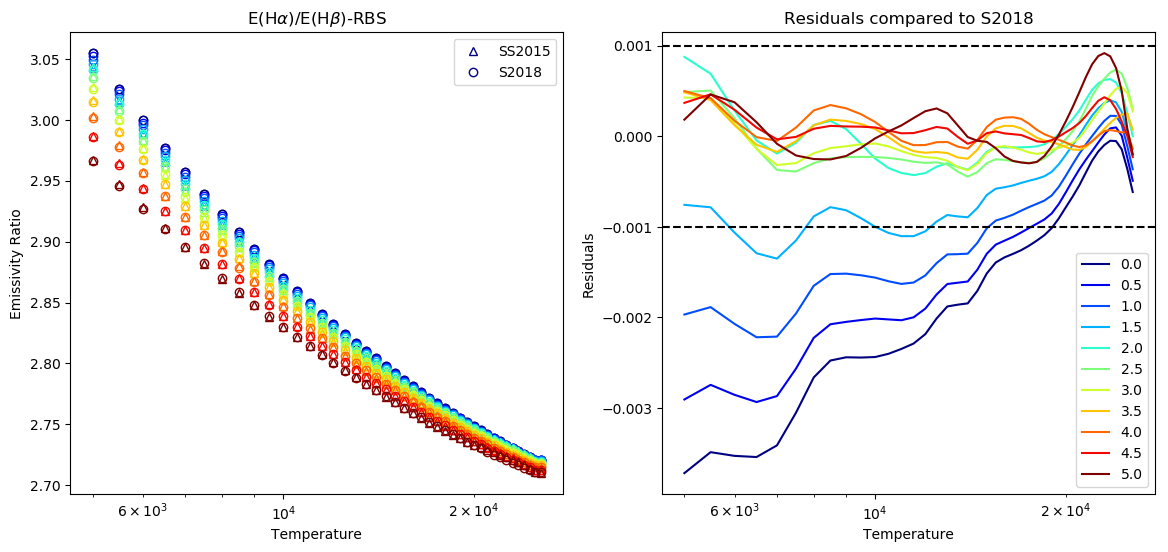

In [82]:
# Open .pdf to save emissivity and residual plots in
RBS_ha_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/RBS_halpha.pdf')

ha_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

color = cm.jet(np.linspace(0,1,len(refined_ne_array)))

for i in range(len(extrap_ne_array)):
    ax1.plot(refined_T_array, SS2015_ha_interp(refined_T_array, extrap_ne_array[i])/SS2015_hb_interp(refined_T_array, extrap_ne_array[i]), marker='^', linestyle='None', fillstyle='none', color=color[i])
    ax1.plot(refined_T_array, S2018_ha_interp(refined_T_array, extrap_ne_array[i])/S2018_hb_interp(refined_T_array, extrap_ne_array[i]), marker='o', linestyle='None', fillstyle='none', color=color[i])
    ax2.plot(refined_T_array, ((SS2015_ha_interp(refined_T_array, extrap_ne_array[i])/SS2015_hb_interp(refined_T_array, extrap_ne_array[i]))-(S2018_ha_interp(refined_T_array, extrap_ne_array[i])/S2018_hb_interp(refined_T_array, extrap_ne_array[i])))/(S2018_ha_interp(refined_T_array, extrap_ne_array[i])/S2018_hb_interp(refined_T_array, extrap_ne_array[i])), \
            color=color[i], label=str(extrap_ne_array[i]))
    if i == 0:
        ax1.plot(refined_T_array, SS2015_ha_interp(refined_T_array, extrap_ne_array[i])/SS2015_hb_interp(refined_T_array, extrap_ne_array[i]), label='SS2015', marker='^', linestyle='None', fillstyle='none', color=color[i])
        ax1.plot(refined_T_array, S2018_ha_interp(refined_T_array, extrap_ne_array[i])/S2018_hb_interp(refined_T_array, extrap_ne_array[i]), label='S2018', marker='o', linestyle='None', fillstyle='none', color=color[i])



ax1.set_xscale('log')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Emissivity Ratio')
ax1.set_title(r'E(H$\alpha$)/E(H$\beta$)-RBS')
ax1.legend()
              
ax2.axhline(0.001, ls='--', color='black')
ax2.axhline(-0.001, ls='--', color='black')
ax2.set_xscale('log')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Residuals')
ax2.set_title('Residuals compared to S2018')
ax2.legend()

plt.show()
RBS_ha_pdf.savefig(ha_f)
RBS_ha_pdf.close()


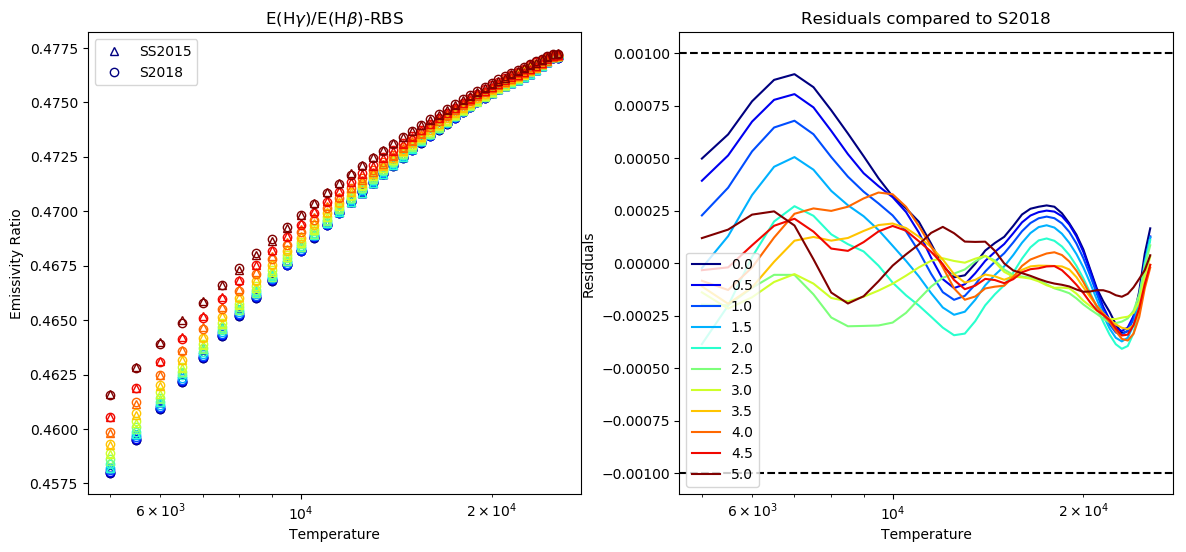

In [85]:
# Open .pdf to save emissivity and residual plots in
RBS_hg_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/RBS_hgamma.pdf')

hg_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

color = cm.jet(np.linspace(0,1,len(refined_ne_array)))

for i in range(len(extrap_ne_array)):
    ax1.plot(refined_T_array, SS2015_hg_interp(refined_T_array, extrap_ne_array[i])/SS2015_hb_interp(refined_T_array, extrap_ne_array[i]), marker='^', linestyle='None', fillstyle='none', color=color[i])
    ax1.plot(refined_T_array, S2018_hg_interp(refined_T_array, extrap_ne_array[i])/S2018_hb_interp(refined_T_array, extrap_ne_array[i]), marker='o', linestyle='None', fillstyle='none', color=color[i])
    ax2.plot(refined_T_array, ((SS2015_hg_interp(refined_T_array, extrap_ne_array[i])/SS2015_hb_interp(refined_T_array, extrap_ne_array[i]))-(S2018_hg_interp(refined_T_array, extrap_ne_array[i])/S2018_hb_interp(refined_T_array, extrap_ne_array[i])))/(S2018_hg_interp(refined_T_array, extrap_ne_array[i])/S2018_hb_interp(refined_T_array, extrap_ne_array[i])), \
            color=color[i], label=str(extrap_ne_array[i]))
    if i == 0:
        ax1.plot(refined_T_array, SS2015_hg_interp(refined_T_array, extrap_ne_array[i])/SS2015_hb_interp(refined_T_array, extrap_ne_array[i]), label='SS2015', marker='^', linestyle='None', fillstyle='none', color=color[i])
        ax1.plot(refined_T_array, S2018_hg_interp(refined_T_array, extrap_ne_array[i])/S2018_hb_interp(refined_T_array, extrap_ne_array[i]), label='S2018', marker='o', linestyle='None', fillstyle='none', color=color[i])



ax1.set_xscale('log')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Emissivity Ratio')
ax1.set_title(r'E(H$\gamma$)/E(H$\beta$)-RBS')
ax1.legend()
              
ax2.axhline(0.001, ls='--', color='black')
ax2.axhline(-0.001, ls='--', color='black')
ax2.set_xscale('log')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Residuals')
ax2.set_title('Residuals compared to S2018')
ax2.legend()

plt.show()
RBS_hg_pdf.savefig(hg_f)
RBS_hg_pdf.close()

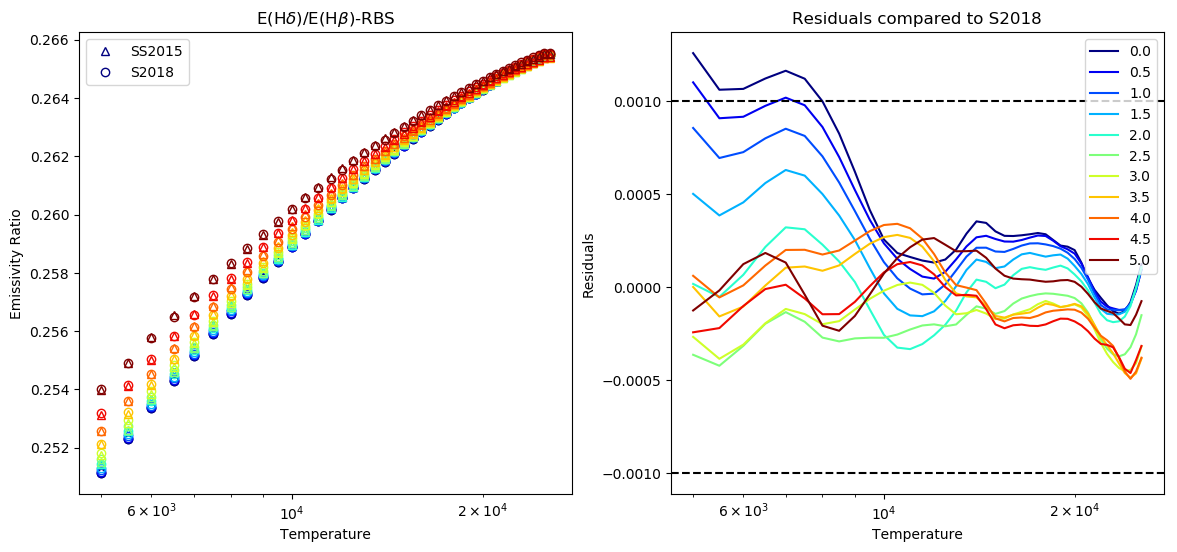

In [86]:
# Open .pdf to save emissivity and residual plots in
RBS_hd_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/RBS_hdelta.pdf')

hd_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

color = cm.jet(np.linspace(0,1,len(refined_ne_array)))

for i in range(len(extrap_ne_array)):
    ax1.plot(refined_T_array, SS2015_hd_interp(refined_T_array, extrap_ne_array[i])/SS2015_hb_interp(refined_T_array, extrap_ne_array[i]), marker='^', linestyle='None', fillstyle='none', color=color[i])
    ax1.plot(refined_T_array, S2018_hd_interp(refined_T_array, extrap_ne_array[i])/S2018_hb_interp(refined_T_array, extrap_ne_array[i]), marker='o', linestyle='None', fillstyle='none', color=color[i])
    ax2.plot(refined_T_array, ((SS2015_hd_interp(refined_T_array, extrap_ne_array[i])/SS2015_hb_interp(refined_T_array, extrap_ne_array[i]))-(S2018_hd_interp(refined_T_array, extrap_ne_array[i])/S2018_hb_interp(refined_T_array, extrap_ne_array[i])))/(S2018_hd_interp(refined_T_array, extrap_ne_array[i])/S2018_hb_interp(refined_T_array, extrap_ne_array[i])), \
            color=color[i], label=str(extrap_ne_array[i]))
    if i == 0:
        ax1.plot(refined_T_array, SS2015_hd_interp(refined_T_array, extrap_ne_array[i])/SS2015_hb_interp(refined_T_array, extrap_ne_array[i]), label='SS2015', marker='^', linestyle='None', fillstyle='none', color=color[i])
        ax1.plot(refined_T_array, S2018_hd_interp(refined_T_array, extrap_ne_array[i])/S2018_hb_interp(refined_T_array, extrap_ne_array[i]), label='S2018', marker='o', linestyle='None', fillstyle='none', color=color[i])



ax1.set_xscale('log')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Emissivity Ratio')
ax1.set_title(r'E(H$\delta$)/E(H$\beta$)-RBS')
ax1.legend()
              
ax2.axhline(0.001, ls='--', color='black')
ax2.axhline(-0.001, ls='--', color='black')
ax2.set_xscale('log')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Residuals')
ax2.set_title('Residuals compared to S2018')
ax2.legend()

plt.show()
RBS_hd_pdf.savefig(hd_f)
RBS_hd_pdf.close()



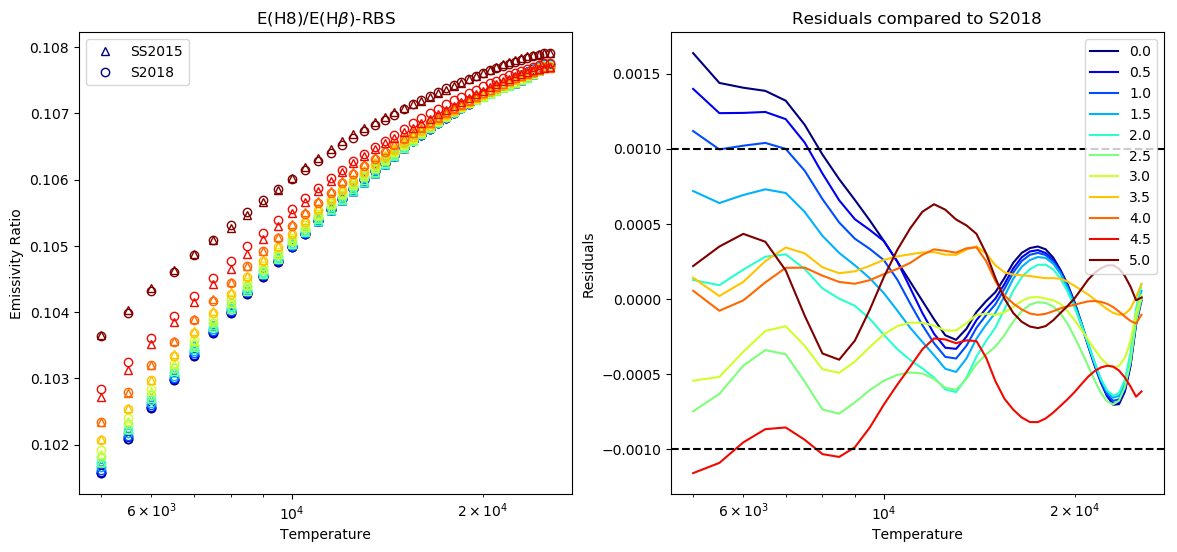

In [87]:
# Open .pdf to save emissivity and residual plots in
RBS_h8_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/RBS_H8.pdf')

h8_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

color = cm.jet(np.linspace(0,1,len(refined_ne_array)))

for i in range(len(extrap_ne_array)):
    ax1.plot(refined_T_array, SS2015_h8_interp(refined_T_array, extrap_ne_array[i])/SS2015_hb_interp(refined_T_array, extrap_ne_array[i]), marker='^', linestyle='None', fillstyle='none', color=color[i])
    ax1.plot(refined_T_array, S2018_h8_interp(refined_T_array, extrap_ne_array[i])/S2018_hb_interp(refined_T_array, extrap_ne_array[i]), marker='o', linestyle='None', fillstyle='none', color=color[i])
    ax2.plot(refined_T_array, ((SS2015_h8_interp(refined_T_array, extrap_ne_array[i])/SS2015_hb_interp(refined_T_array, extrap_ne_array[i]))-(S2018_h8_interp(refined_T_array, extrap_ne_array[i])/S2018_hb_interp(refined_T_array, extrap_ne_array[i])))/(S2018_h8_interp(refined_T_array, extrap_ne_array[i])/S2018_hb_interp(refined_T_array, extrap_ne_array[i])), \
            color=color[i], label=str(extrap_ne_array[i]))
    if i == 0:
        ax1.plot(refined_T_array, SS2015_h8_interp(refined_T_array, extrap_ne_array[i])/SS2015_hb_interp(refined_T_array, extrap_ne_array[i]), label='SS2015', marker='^', linestyle='None', fillstyle='none', color=color[i])
        ax1.plot(refined_T_array, S2018_h8_interp(refined_T_array, extrap_ne_array[i])/S2018_hb_interp(refined_T_array, extrap_ne_array[i]), label='S2018', marker='o', linestyle='None', fillstyle='none', color=color[i])



ax1.set_xscale('log')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Emissivity Ratio')
ax1.set_title(r'E(H8)/E(H$\beta$)-RBS')
ax1.legend()
              
ax2.axhline(0.001, ls='--', color='black')
ax2.axhline(-0.001, ls='--', color='black')
ax2.set_xscale('log')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Residuals')
ax2.set_title('Residuals compared to S2018')
ax2.legend()

plt.show()
RBS_h8_pdf.savefig(h8_f)
RBS_h8_pdf.close()



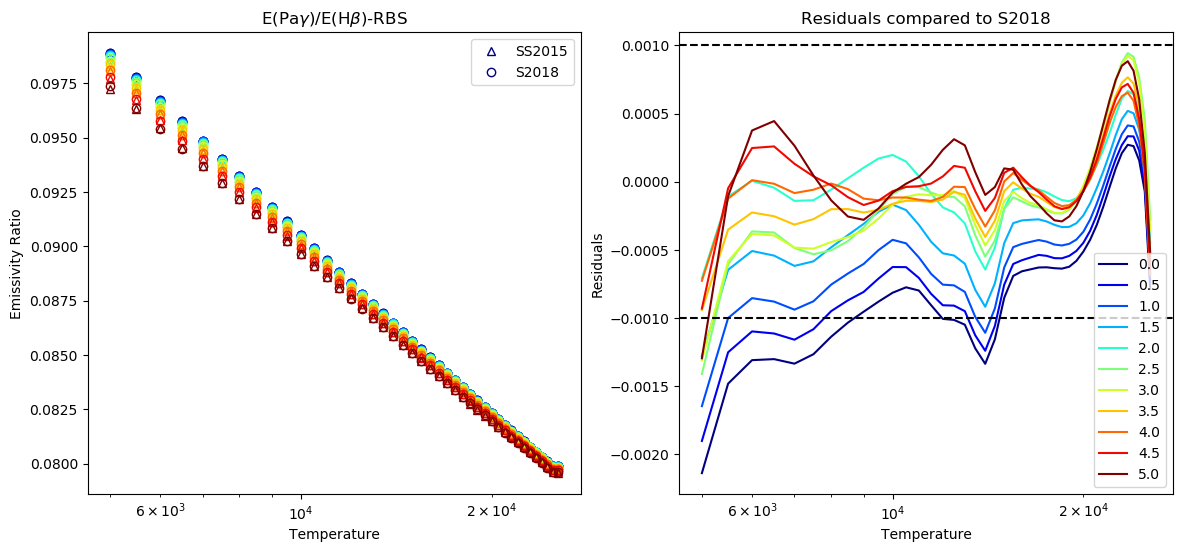

In [88]:
# Open .pdf to save emissivity and residual plots in
RBS_pg_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/RBS_pgamma.pdf')

pg_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

color = cm.jet(np.linspace(0,1,len(refined_ne_array)))

for i in range(len(extrap_ne_array)):
    ax1.plot(refined_T_array, SS2015_pg_interp(refined_T_array, extrap_ne_array[i])/SS2015_hb_interp(refined_T_array, extrap_ne_array[i]), marker='^', linestyle='None', fillstyle='none', color=color[i])
    ax1.plot(refined_T_array, S2018_pg_interp(refined_T_array, extrap_ne_array[i])/S2018_hb_interp(refined_T_array, extrap_ne_array[i]), marker='o', linestyle='None', fillstyle='none', color=color[i])
    ax2.plot(refined_T_array, ((SS2015_pg_interp(refined_T_array, extrap_ne_array[i])/SS2015_hb_interp(refined_T_array, extrap_ne_array[i]))-(S2018_pg_interp(refined_T_array, extrap_ne_array[i])/S2018_hb_interp(refined_T_array, extrap_ne_array[i])))/(S2018_pg_interp(refined_T_array, extrap_ne_array[i])/S2018_hb_interp(refined_T_array, extrap_ne_array[i])), \
            color=color[i], label=str(extrap_ne_array[i]))
    if i == 0:
        ax1.plot(refined_T_array, SS2015_pg_interp(refined_T_array, extrap_ne_array[i])/SS2015_hb_interp(refined_T_array, extrap_ne_array[i]), label='SS2015', marker='^', linestyle='None', fillstyle='none', color=color[i])
        ax1.plot(refined_T_array, S2018_pg_interp(refined_T_array, extrap_ne_array[i])/S2018_hb_interp(refined_T_array, extrap_ne_array[i]), label='S2018', marker='o', linestyle='None', fillstyle='none', color=color[i])



ax1.set_xscale('log')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Emissivity Ratio')
ax1.set_title(r'E(Pa$\gamma$)/E(H$\beta$)-RBS')
ax1.legend()
              
ax2.axhline(0.001, ls='--', color='black')
ax2.axhline(-0.001, ls='--', color='black')
ax2.set_xscale('log')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Residuals')
ax2.set_title('Residuals compared to S2018')
ax2.legend()

plt.show()
RBS_pg_pdf.savefig(pg_f)
RBS_pg_pdf.close()



## PCA then RectBivariateSpline

In [40]:
SS2015_ha_PCAinterp = RectBivariateSpline(SS2015_temps, extrap_ne_array, SS2015_ha_extfit, kx=3, ky=3)
SS2015_hb_PCAinterp = RectBivariateSpline(SS2015_temps, extrap_ne_array, SS2015_hb_extfit, kx=3, ky=3)
SS2015_hg_PCAinterp = RectBivariateSpline(SS2015_temps, extrap_ne_array, SS2015_hg_extfit, kx=3, ky=3)
SS2015_hd_PCAinterp = RectBivariateSpline(SS2015_temps, extrap_ne_array, SS2015_hd_extfit, kx=3, ky=3)
SS2015_h8_PCAinterp = RectBivariateSpline(SS2015_temps, extrap_ne_array, SS2015_h8_extfit, kx=3, ky=3)
SS2015_pg_PCAinterp = RectBivariateSpline(SS2015_temps, extrap_ne_array, SS2015_pg_extfit, kx=3, ky=3)

S2018_ha_PCAinterp = RectBivariateSpline(S2018_temps, refined_ne_array, S2018_ha_extfit, kx=3, ky=3)
S2018_hb_PCAinterp = RectBivariateSpline(S2018_temps, refined_ne_array, S2018_hb_extfit, kx=3, ky=3)
S2018_hg_PCAinterp = RectBivariateSpline(S2018_temps, refined_ne_array, S2018_hg_extfit, kx=3, ky=3)
S2018_hd_PCAinterp = RectBivariateSpline(S2018_temps, refined_ne_array, S2018_hd_extfit, kx=3, ky=3)
S2018_h8_PCAinterp = RectBivariateSpline(S2018_temps, refined_ne_array, S2018_h8_extfit, kx=3, ky=3)
S2018_pg_PCAinterp = RectBivariateSpline(S2018_temps, refined_ne_array, S2018_pg_extfit, kx=3, ky=3)


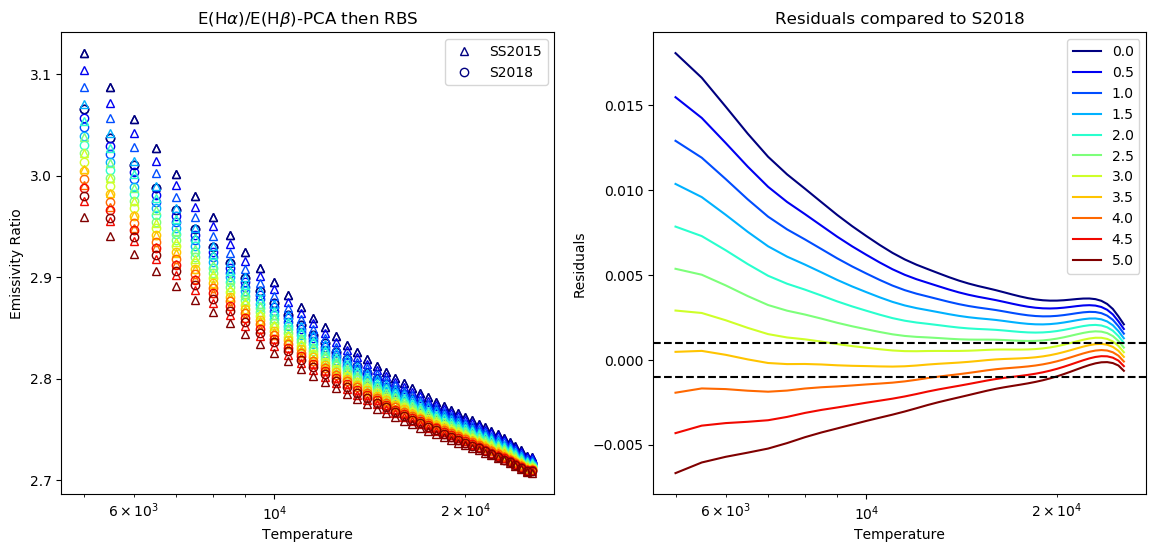

In [83]:
# Open .pdf to save emissivity and residual plots in
PCA_RBS_ha_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/PCA_then_RBS_halpha.pdf')

ha_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

color = cm.jet(np.linspace(0,1,len(refined_ne_array)))

for i in range(len(extrap_ne_array)):
    ax1.plot(refined_T_array, SS2015_ha_PCAinterp(refined_T_array, extrap_ne_array[i])/SS2015_hb_PCAinterp(refined_T_array, extrap_ne_array[i]), marker='^', linestyle='None', fillstyle='none', color=color[i])
    ax1.plot(refined_T_array, S2018_ha_PCAinterp(refined_T_array, extrap_ne_array[i])/S2018_hb_PCAinterp(refined_T_array, extrap_ne_array[i]), marker='o', linestyle='None', fillstyle='none', color=color[i])
    ax2.plot(refined_T_array, ((SS2015_ha_PCAinterp(refined_T_array, extrap_ne_array[i])/SS2015_hb_PCAinterp(refined_T_array, extrap_ne_array[i]))-(S2018_ha_PCAinterp(refined_T_array, extrap_ne_array[i])/S2018_hb_PCAinterp(refined_T_array, extrap_ne_array[i])))/(S2018_ha_PCAinterp(refined_T_array, extrap_ne_array[i])/S2018_hb_PCAinterp(refined_T_array, extrap_ne_array[i])), \
            color=color[i], label=str(extrap_ne_array[i]))
    if i == 0:
        ax1.plot(refined_T_array, SS2015_ha_PCAinterp(refined_T_array, extrap_ne_array[i])/SS2015_hb_PCAinterp(refined_T_array, extrap_ne_array[i]), label='SS2015', marker='^', linestyle='None', fillstyle='none', color=color[i])
        ax1.plot(refined_T_array, S2018_ha_PCAinterp(refined_T_array, extrap_ne_array[i])/S2018_hb_PCAinterp(refined_T_array, extrap_ne_array[i]), label='S2018', marker='o', linestyle='None', fillstyle='none', color=color[i])



ax1.set_xscale('log')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Emissivity Ratio')
ax1.set_title(r'E(H$\alpha$)/E(H$\beta$)-PCA then RBS')
ax1.legend()
              
ax2.axhline(0.001, ls='--', color='black')
ax2.axhline(-0.001, ls='--', color='black')
ax2.set_xscale('log')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Residuals')
ax2.set_title('Residuals compared to S2018')
ax2.legend()

plt.show()
PCA_RBS_ha_pdf.savefig(ha_f)
PCA_RBS_ha_pdf.close()


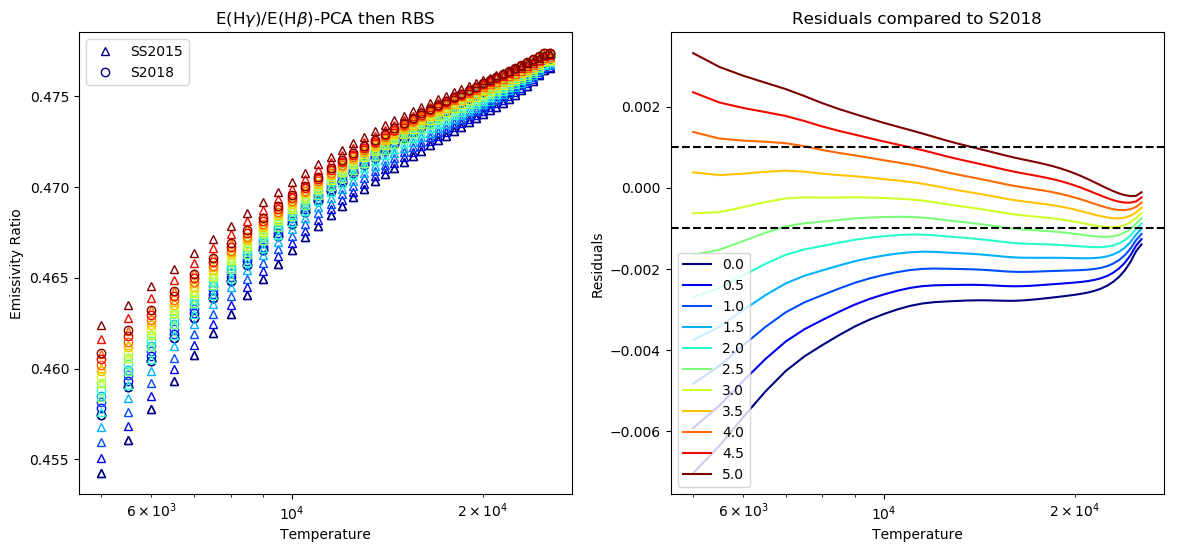

In [89]:
# Open .pdf to save emissivity and residual plots in
PCA_RBS_hg_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/PCA_then_RBS_hgamma.pdf')

hg_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

color = cm.jet(np.linspace(0,1,len(refined_ne_array)))

for i in range(len(extrap_ne_array)):
    ax1.plot(refined_T_array, SS2015_hg_PCAinterp(refined_T_array, extrap_ne_array[i])/SS2015_hb_PCAinterp(refined_T_array, extrap_ne_array[i]), marker='^', linestyle='None', fillstyle='none', color=color[i])
    ax1.plot(refined_T_array, S2018_hg_PCAinterp(refined_T_array, extrap_ne_array[i])/S2018_hb_PCAinterp(refined_T_array, extrap_ne_array[i]), marker='o', linestyle='None', fillstyle='none', color=color[i])
    ax2.plot(refined_T_array, ((SS2015_hg_PCAinterp(refined_T_array, extrap_ne_array[i])/SS2015_hb_PCAinterp(refined_T_array, extrap_ne_array[i]))-(S2018_hg_PCAinterp(refined_T_array, extrap_ne_array[i])/S2018_hb_PCAinterp(refined_T_array, extrap_ne_array[i])))/(S2018_hg_PCAinterp(refined_T_array, extrap_ne_array[i])/S2018_hb_PCAinterp(refined_T_array, extrap_ne_array[i])), \
            color=color[i], label=str(extrap_ne_array[i]))
    if i == 0:
        ax1.plot(refined_T_array, SS2015_hg_PCAinterp(refined_T_array, extrap_ne_array[i])/SS2015_hb_PCAinterp(refined_T_array, extrap_ne_array[i]), label='SS2015', marker='^', linestyle='None', fillstyle='none', color=color[i])
        ax1.plot(refined_T_array, S2018_hg_PCAinterp(refined_T_array, extrap_ne_array[i])/S2018_hb_PCAinterp(refined_T_array, extrap_ne_array[i]), label='S2018', marker='o', linestyle='None', fillstyle='none', color=color[i])



ax1.set_xscale('log')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Emissivity Ratio')
ax1.set_title(r'E(H$\gamma$)/E(H$\beta$)-PCA then RBS')
ax1.legend()
              
ax2.axhline(0.001, ls='--', color='black')
ax2.axhline(-0.001, ls='--', color='black')
ax2.set_xscale('log')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Residuals')
ax2.set_title('Residuals compared to S2018')
ax2.legend()

plt.show()
PCA_RBS_hg_pdf.savefig(hg_f)
PCA_RBS_hg_pdf.close()



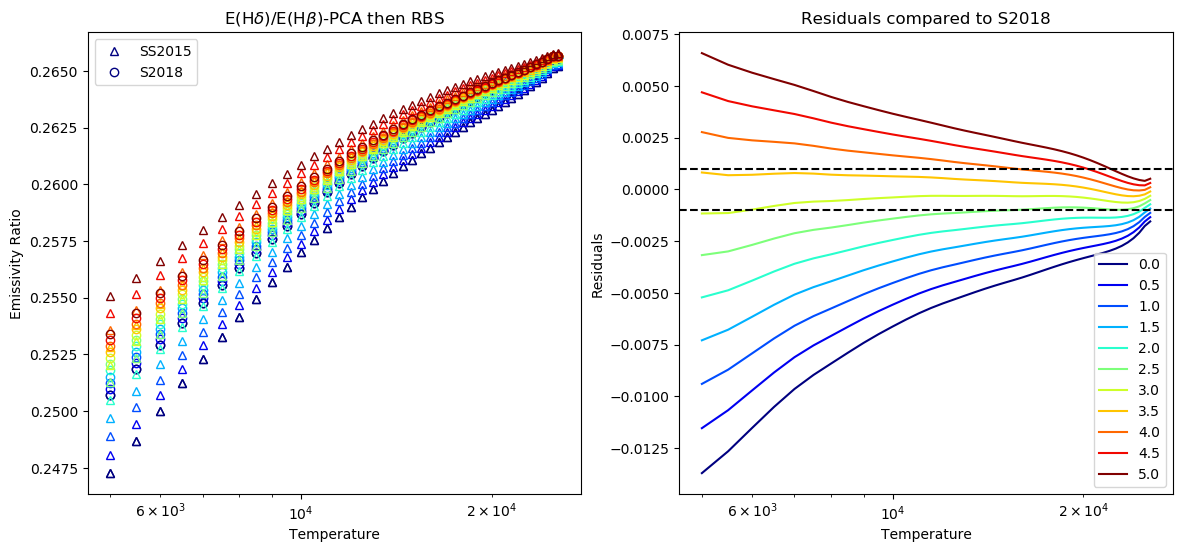

In [90]:
# Open .pdf to save emissivity and residual plots in
PCA_RBS_hd_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/PCA_then_RBS_hdelta.pdf')

hd_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

color = cm.jet(np.linspace(0,1,len(refined_ne_array)))

for i in range(len(extrap_ne_array)):
    ax1.plot(refined_T_array, SS2015_hd_PCAinterp(refined_T_array, extrap_ne_array[i])/SS2015_hb_PCAinterp(refined_T_array, extrap_ne_array[i]), marker='^', linestyle='None', fillstyle='none', color=color[i])
    ax1.plot(refined_T_array, S2018_hd_PCAinterp(refined_T_array, extrap_ne_array[i])/S2018_hb_PCAinterp(refined_T_array, extrap_ne_array[i]), marker='o', linestyle='None', fillstyle='none', color=color[i])
    ax2.plot(refined_T_array, ((SS2015_hd_PCAinterp(refined_T_array, extrap_ne_array[i])/SS2015_hb_PCAinterp(refined_T_array, extrap_ne_array[i]))-(S2018_hd_PCAinterp(refined_T_array, extrap_ne_array[i])/S2018_hb_PCAinterp(refined_T_array, extrap_ne_array[i])))/(S2018_hd_PCAinterp(refined_T_array, extrap_ne_array[i])/S2018_hb_PCAinterp(refined_T_array, extrap_ne_array[i])), \
            color=color[i], label=str(extrap_ne_array[i]))
    if i == 0:
        ax1.plot(refined_T_array, SS2015_hd_PCAinterp(refined_T_array, extrap_ne_array[i])/SS2015_hb_PCAinterp(refined_T_array, extrap_ne_array[i]), label='SS2015', marker='^', linestyle='None', fillstyle='none', color=color[i])
        ax1.plot(refined_T_array, S2018_hd_PCAinterp(refined_T_array, extrap_ne_array[i])/S2018_hb_PCAinterp(refined_T_array, extrap_ne_array[i]), label='S2018', marker='o', linestyle='None', fillstyle='none', color=color[i])



ax1.set_xscale('log')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Emissivity Ratio')
ax1.set_title(r'E(H$\delta$)/E(H$\beta$)-PCA then RBS')
ax1.legend()
              
ax2.axhline(0.001, ls='--', color='black')
ax2.axhline(-0.001, ls='--', color='black')
ax2.set_xscale('log')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Residuals')
ax2.set_title('Residuals compared to S2018')
ax2.legend()

plt.show()
PCA_RBS_hd_pdf.savefig(hd_f)
PCA_RBS_hd_pdf.close()


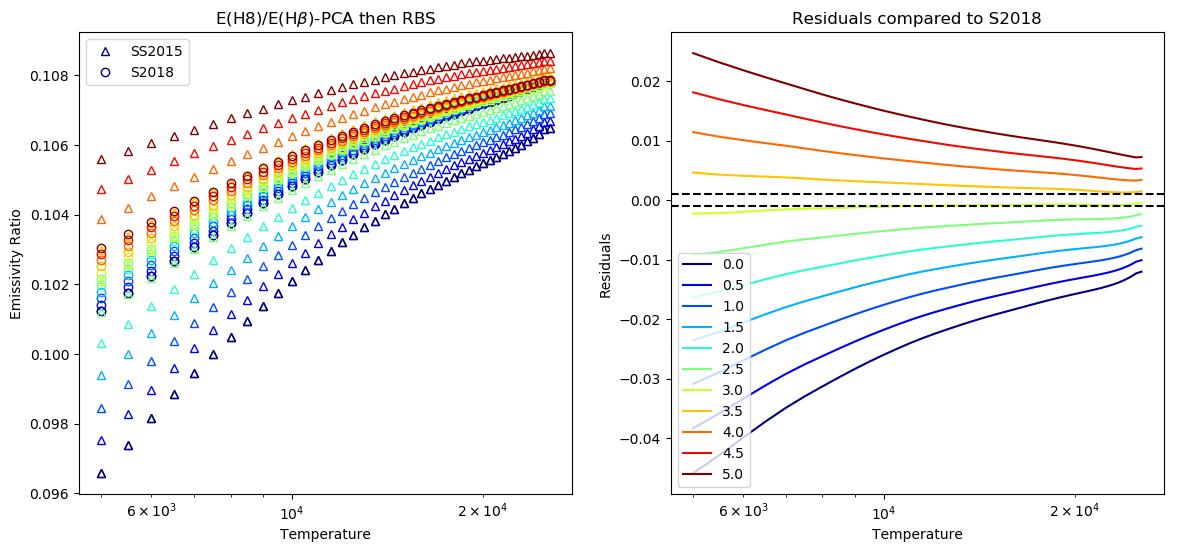

In [91]:
# Open .pdf to save emissivity and residual plots in
PCA_RBS_h8_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/PCA_then_RBS_h8.pdf')

h8_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

color = cm.jet(np.linspace(0,1,len(refined_ne_array)))

for i in range(len(extrap_ne_array)):
    ax1.plot(refined_T_array, SS2015_h8_PCAinterp(refined_T_array, extrap_ne_array[i])/SS2015_hb_PCAinterp(refined_T_array, extrap_ne_array[i]), marker='^', linestyle='None', fillstyle='none', color=color[i])
    ax1.plot(refined_T_array, S2018_h8_PCAinterp(refined_T_array, extrap_ne_array[i])/S2018_hb_PCAinterp(refined_T_array, extrap_ne_array[i]), marker='o', linestyle='None', fillstyle='none', color=color[i])
    ax2.plot(refined_T_array, ((SS2015_h8_PCAinterp(refined_T_array, extrap_ne_array[i])/SS2015_hb_PCAinterp(refined_T_array, extrap_ne_array[i]))-(S2018_h8_PCAinterp(refined_T_array, extrap_ne_array[i])/S2018_hb_PCAinterp(refined_T_array, extrap_ne_array[i])))/(S2018_h8_PCAinterp(refined_T_array, extrap_ne_array[i])/S2018_hb_PCAinterp(refined_T_array, extrap_ne_array[i])), \
            color=color[i], label=str(extrap_ne_array[i]))
    if i == 0:
        ax1.plot(refined_T_array, SS2015_h8_PCAinterp(refined_T_array, extrap_ne_array[i])/SS2015_hb_PCAinterp(refined_T_array, extrap_ne_array[i]), label='SS2015', marker='^', linestyle='None', fillstyle='none', color=color[i])
        ax1.plot(refined_T_array, S2018_h8_PCAinterp(refined_T_array, extrap_ne_array[i])/S2018_hb_PCAinterp(refined_T_array, extrap_ne_array[i]), label='S2018', marker='o', linestyle='None', fillstyle='none', color=color[i])



ax1.set_xscale('log')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Emissivity Ratio')
ax1.set_title(r'E(H8)/E(H$\beta$)-PCA then RBS')
ax1.legend()
              
ax2.axhline(0.001, ls='--', color='black')
ax2.axhline(-0.001, ls='--', color='black')
ax2.set_xscale('log')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Residuals')
ax2.set_title('Residuals compared to S2018')
ax2.legend()

plt.show()
PCA_RBS_h8_pdf.savefig(h8_f)
PCA_RBS_h8_pdf.close()


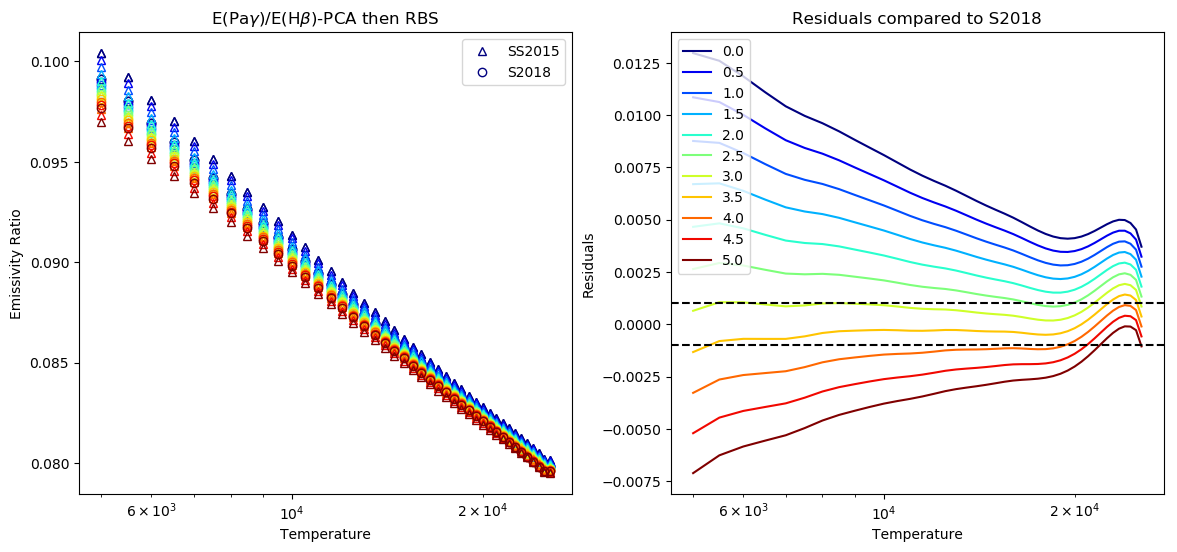

In [92]:
# Open .pdf to save emissivity and residual plots in
PCA_RBS_pg_pdf = matplotlib.backends.backend_pdf.PdfPages('/Users/thsyu/Dropbox/BCDs/primordial_helium/PCA_then_RBS_pgamma.pdf')

pg_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

color = cm.jet(np.linspace(0,1,len(refined_ne_array)))

for i in range(len(extrap_ne_array)):
    ax1.plot(refined_T_array, SS2015_pg_PCAinterp(refined_T_array, extrap_ne_array[i])/SS2015_hb_PCAinterp(refined_T_array, extrap_ne_array[i]), marker='^', linestyle='None', fillstyle='none', color=color[i])
    ax1.plot(refined_T_array, S2018_pg_PCAinterp(refined_T_array, extrap_ne_array[i])/S2018_hb_PCAinterp(refined_T_array, extrap_ne_array[i]), marker='o', linestyle='None', fillstyle='none', color=color[i])
    ax2.plot(refined_T_array, ((SS2015_pg_PCAinterp(refined_T_array, extrap_ne_array[i])/SS2015_hb_PCAinterp(refined_T_array, extrap_ne_array[i]))-(S2018_pg_PCAinterp(refined_T_array, extrap_ne_array[i])/S2018_hb_PCAinterp(refined_T_array, extrap_ne_array[i])))/(S2018_pg_PCAinterp(refined_T_array, extrap_ne_array[i])/S2018_hb_PCAinterp(refined_T_array, extrap_ne_array[i])), \
            color=color[i], label=str(extrap_ne_array[i]))
    if i == 0:
        ax1.plot(refined_T_array, SS2015_pg_PCAinterp(refined_T_array, extrap_ne_array[i])/SS2015_hb_PCAinterp(refined_T_array, extrap_ne_array[i]), label='SS2015', marker='^', linestyle='None', fillstyle='none', color=color[i])
        ax1.plot(refined_T_array, S2018_pg_PCAinterp(refined_T_array, extrap_ne_array[i])/S2018_hb_PCAinterp(refined_T_array, extrap_ne_array[i]), label='S2018', marker='o', linestyle='None', fillstyle='none', color=color[i])



ax1.set_xscale('log')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Emissivity Ratio')
ax1.set_title(r'E(Pa$\gamma$)/E(H$\beta$)-PCA then RBS')
ax1.legend()
              
ax2.axhline(0.001, ls='--', color='black')
ax2.axhline(-0.001, ls='--', color='black')
ax2.set_xscale('log')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Residuals')
ax2.set_title('Residuals compared to S2018')
ax2.legend()

plt.show()
PCA_RBS_pg_pdf.savefig(pg_f)
PCA_RBS_pg_pdf.close()


In [93]:
path

'/Users/thsyu/Software/Yp'